In [1]:
#libaries
import numpy as np
import pandas as pd

import os
import tarfile
import urllib
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.compose import ColumnTransformer


%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
# Allows feeding a pandas dataframe containing non-numerical values directly into a pipeline - drops them
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

    # Definition of the CategoricalEncoder class, copied from PR #9151.
    # Just run this cell, or copy it to your code, do not try to understand it (yet).

    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.utils import check_array
    from sklearn.preprocessing import LabelEncoder
    from scipy import sparse
# Present in SKlearn .20 dev0
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out
        
import os
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./images/", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [3]:
# read in the data: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

WEATHER_PATH = os.path.join("datasets", "weather")
WEATHER_URL = "https://rattle.togaware.com/weatherAUS.csv"
def fetch_weather_data(weather_url=WEATHER_URL, weather_path=WEATHER_PATH):
    if not os.path.isdir(weather_path):
        os.makedirs(weather_path)
    tgz_path = os.path.join(weather_path, "weatherAUS.csv")
    urllib.request.urlretrieve(weather_url, tgz_path)
    return pd.read_csv(tgz_path)
    
weather = fetch_weather_data()   
weather.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [4]:
weather.info()
weather.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145463 entries, 0 to 145462
Data columns (total 24 columns):
Date             145463 non-null object
Location         145463 non-null object
MinTemp          143918 non-null float64
MaxTemp          144128 non-null float64
Rainfall         142245 non-null float64
Evaporation      80663 non-null float64
Sunshine         74643 non-null float64
WindGustDir      134733 non-null object
WindGustSpeed    134796 non-null float64
WindDir9am       134434 non-null object
WindDir3pm       140887 non-null object
WindSpeed9am     143382 non-null float64
WindSpeed3pm     142056 non-null float64
Humidity9am      142884 non-null float64
Humidity3pm      141051 non-null float64
Pressure9am      130109 non-null float64
Pressure3pm      130114 non-null float64
Cloud9am         88420 non-null float64
Cloud3pm         85047 non-null float64
Temp9am          143712 non-null float64
Temp3pm          141892 non-null float64
RainToday        142245 non-null obje

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [5]:
weather[weather.isnull().any(axis=1)].head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [6]:
print(weather.shape)
weather.columns #dataset categories

(145463, 24)


Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [7]:
weather['RainTomorrow'].value_counts()

No     110992
Yes     31254
Name: RainTomorrow, dtype: int64

In [53]:
corr = weather.corr()
corr.style.background_gradient()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
MinTemp,1,0.736009,0.107113,0.47767,0.0764192,0.186646,0.184237,0.181025,-0.23799,0.00723046,-0.46281,-0.470673,0.0800886,0.0223726,0.902579,0.708191,0.129274
MaxTemp,0.736009,1,-0.0705652,0.598498,0.470523,0.0723976,0.0190687,0.0528728,-0.50817,-0.508783,-0.347494,-0.442644,-0.28426,-0.273318,0.886429,0.984618,-0.0404151
Rainfall,0.107113,-0.0705652,1,-0.067886,-0.229175,0.131653,0.0855302,0.0548372,0.22217,0.257287,-0.161563,-0.118906,0.196999,0.174171,0.0158091,-0.0760535,0.313209
Evaporation,0.47767,0.598498,-0.067886,1,0.365654,0.210353,0.194866,0.134557,-0.509833,-0.395106,-0.280644,-0.302855,-0.183403,-0.182044,0.555441,0.584266,-0.0422864
Sunshine,0.0764192,0.470523,-0.229175,0.365654,1,-0.0386521,0.00208544,0.0510123,-0.486063,-0.626108,0.0370885,-0.0246891,-0.673523,-0.701052,0.292647,0.491212,-0.296351
WindGustSpeed,0.186646,0.0723976,0.131653,0.210353,-0.0386521,1,0.607214,0.688727,-0.217842,-0.0245104,-0.460483,-0.413971,0.0737146,0.111222,0.158511,0.0370642,0.16305
WindSpeed9am,0.184237,0.0190687,0.0855302,0.194866,0.00208544,0.607214,1,0.521668,-0.271443,-0.0289839,-0.230055,-0.176568,0.02936,0.0589609,0.137023,0.00835491,0.0717705
WindSpeed3pm,0.181025,0.0528728,0.0548372,0.134557,0.0510123,0.688727,0.521668,1,-0.1469,0.0189372,-0.299547,-0.257558,0.0548948,0.0277491,0.167754,0.0297811,0.0498129
Humidity9am,-0.23799,-0.50817,0.22217,-0.509833,-0.486063,-0.217842,-0.271443,-0.1469,1,0.666271,0.147661,0.197254,0.444934,0.3521,-0.475544,-0.502932,0.170007
Humidity3pm,0.00723046,-0.508783,0.257287,-0.395106,-0.626108,-0.0245104,-0.0289839,0.0189372,0.666271,1,-0.0213361,0.0624218,0.511272,0.51974,-0.219879,-0.558711,0.310769


In [9]:
corr['Rainfall'].sort_values(ascending=False)

Rainfall         1.000000
RISK_MM          0.313209
Humidity3pm      0.257287
Humidity9am      0.222170
Cloud9am         0.196999
Cloud3pm         0.174171
WindGustSpeed    0.131653
MinTemp          0.107113
WindSpeed9am     0.085530
WindSpeed3pm     0.054837
Temp9am          0.015809
Evaporation     -0.067886
MaxTemp         -0.070565
Temp3pm         -0.076053
Pressure3pm     -0.118906
Pressure9am     -0.161563
Sunshine        -0.229175
Name: Rainfall, dtype: float64

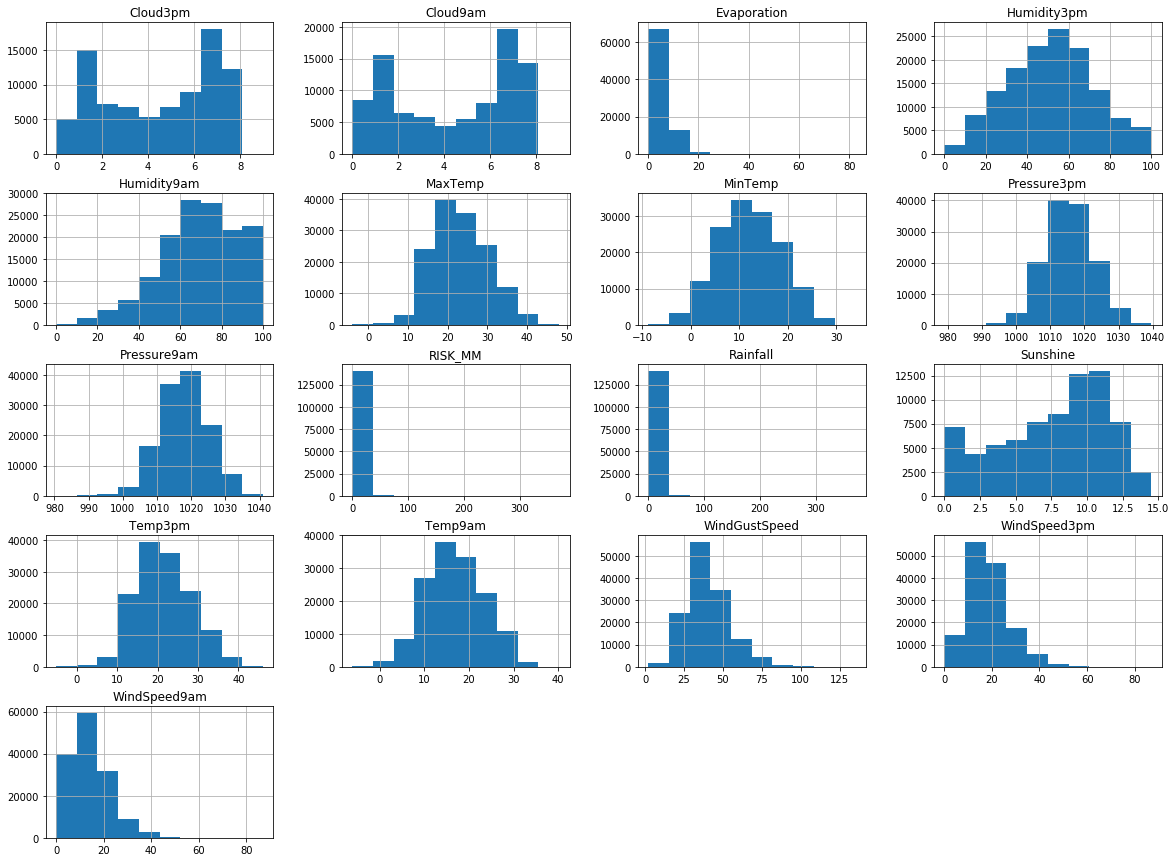

In [10]:
weather.hist(figsize=(20,15))
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

train_set_unshuf, test_set = train_test_split(weather, test_size=0.2, random_state=42)

train_set = np.random.permutation(train_set_unshuf) #will this shuffle with the same permutation?

In [12]:
#convert shuffled numpy array back to pandas dataframe
train_set = pd.DataFrame(data=train_set, columns=weather.columns)
print(train_set.shape)
print(train_set_unshuf.shape)

(116370, 24)
(116370, 24)


In [13]:
#drop unlabeled data
train_set = train_set.dropna(subset=["RainTomorrow"])

In [14]:
weather_labels = train_set['RainTomorrow'].copy()

# binarizes labels 
weather_labels_num = weather_labels.map({"Yes":1, "No":0})#.dropna() #lose ~25000 entrys if drop null rows
weather_labels_num.shape

(113800,)

In [15]:
# gets month, converts to column in dataset
Month = []
for date in train_set['Date']:
    Month.append(float(date[5]+date[6]))
    
train_set['Month'] = Month
train_set.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month
0,2011-03-24,Witchcliffe,14.8,30.4,0,NaN,NaN,SSE,37,E,...,NaN,NaN,NaN,NaN,20,27.6,No,0,No,3.0
1,2009-04-05,BadgerysCreek,15.5,23.7,0,NaN,NaN,NNE,31,WSW,...,1020.2,1014.2,NaN,NaN,19,22.9,No,0.2,No,4.0
2,2014-11-29,Albury,14.7,32.3,0,NaN,NaN,NE,30,SE,...,1016.4,1011.2,2,NaN,22.4,31.5,No,0,No,11.0
3,2014-12-03,Cobar,22.8,34.1,3.6,12.2,NaN,SW,52,NNE,...,1010.4,1010.2,7,7,29.2,25.7,Yes,5.8,Yes,12.0
4,2011-07-14,Cairns,18.3,27.5,0,4.6,5.2,SSE,48,S,...,1017.6,1015.3,6,6,22.6,26,No,0,No,7.0


In [16]:
#************TAKE A LOOK*************
        #moved to up above before dropping null
# train_set.shape
# shuffle_index = np.random.permutation(train_set.shape[0])
# shuffle = np.random.permutation(train_set)
# train_set, weather_labels_num = train_set[shuffle_index], weather_labels_num[shuffle_index]

In [17]:
weather_train = train_set.drop(['RISK_MM','Date','RainTomorrow'], axis=1)
                               # drop RISK_MM because if > 1, rain tomorrow is true. Using as a predictor would give
                               # false appearance of high accuracy
        
weather_train.head()


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month
0,Witchcliffe,14.8,30.4,0,NaN,NaN,SSE,37,E,SE,...,62,45,NaN,NaN,NaN,NaN,20,27.6,No,3.0
1,BadgerysCreek,15.5,23.7,0,NaN,NaN,NNE,31,WSW,NNE,...,67,61,1020.2,1014.2,NaN,NaN,19,22.9,No,4.0
2,Albury,14.7,32.3,0,NaN,NaN,NE,30,SE,ENE,...,53,29,1016.4,1011.2,2,NaN,22.4,31.5,No,11.0
3,Cobar,22.8,34.1,3.6,12.2,NaN,SW,52,NNE,SW,...,43,61,1010.4,1010.2,7,7,29.2,25.7,Yes,12.0
4,Cairns,18.3,27.5,0,4.6,5.2,SSE,48,S,SSE,...,69,59,1017.6,1015.3,6,6,22.6,26,No,7.0


In [18]:
#imputer for cat pipeline
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [19]:

cat_attribs = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Month']
num_attribs = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine','WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm']


cat_pipeline = Pipeline([
#     ('select_cat', DataFrameSelector(cat_attribs)),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

num_pipeline = Pipeline([
#     ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

##FeatureUnion is depricated
# full_pipeline = FeatureUnion(transformer_list=[
#     ("num_pipeline", num_pipeline),
#     ("cat_pipeline", cat_pipeline),
# ])

##ColumnTransformer over FeatureUnion and DataFrameSelector
full_pipeline2 = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])



In [20]:
weather_prepared = full_pipeline2.fit_transform(weather_train)

In [21]:
weather_prepared.shape

(113800, 127)

In [22]:
dfWeatherPrep = pd.DataFrame(weather_prepared)
dfWeatherPrep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113800 entries, 0 to 113799
Columns: 127 entries, 0 to 126
dtypes: float64(127)
memory usage: 110.3 MB


# Test Models

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(weather_prepared, weather_labels_num)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, weather_prepared, weather_labels_num, cv=3, scoring="accuracy")
# Over 80% accuracy. Not terrible.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

array([0.83373754, 0.8436981 , 0.84227454])

In [25]:
#confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

weather_train_pred = cross_val_predict(sgd_clf, weather_prepared, weather_labels_num, cv=3)
print('precision: ', precision_score(weather_labels_num, weather_train_pred))
print('recall: ', recall_score(weather_labels_num, weather_train_pred))


from sklearn.metrics import confusion_matrix
confusion_matrix(weather_labels_num, weather_train_pred)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

precision:  0.7265479670475684
recall:  0.4367586564958664


array([[84645,  4116],
       [14103, 10936]])

In [26]:
# precision // recall scores // F1 score

from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(weather_labels_num, weather_train_pred))
# Really imprecise. 66% precise. Lots of False Positives

print(recall_score(weather_labels_num, weather_train_pred))
# Even less accurate. 52% accurate. Lots of False Negatives.

print(f1_score(weather_labels_num, weather_train_pred))

0.7265479670475684
0.4367586564958664
0.5455588536080417


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

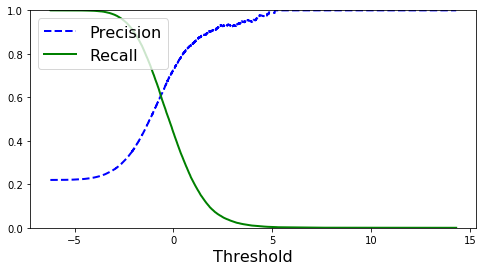

In [27]:
# allows us to compute thresholds for different decision thresholds
weather_scores = cross_val_predict(sgd_clf, weather_prepared, weather_labels_num, cv=3,
                             method="decision_function")


from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(weather_labels_num, weather_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

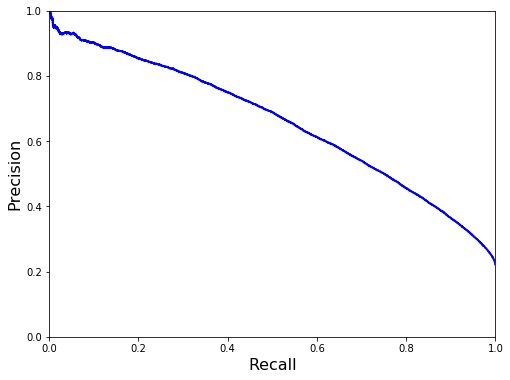

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [29]:
# weird, basically linear, which means an indirect relationshiop. 
# Best precision:recall ratio around 0...
weather_train_pred_50 = (weather_scores > 0) #should this be 50 instead of 25?

print(precision_score(weather_labels_num, weather_train_pred_50))
print(recall_score(weather_labels_num, weather_train_pred_50))

0.7265479670475684
0.4367586564958664


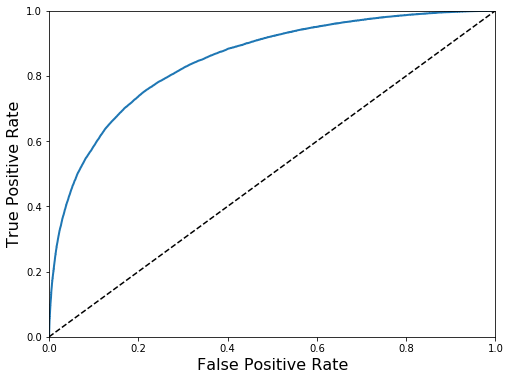

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(weather_labels_num, weather_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [63]:
from sklearn.metrics import roc_auc_score

roc_auc_score(weather_labels_num, weather_scores) #not 1 (perfect), but not .5 (random)

0.8494557734984742

In [73]:
#optimize forest with gridsearch
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
#     {'n_estimators': [4], 'max_features': [40, 80, 115]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50], 'max_features': [40,50,60,70]},
  ]

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring='f1', verbose=2, return_train_score=True)
grid_search.fit(weather_prepared, weather_labels_num)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, max_features=40, n_estimators=50, score=0.6216843734609161, total=  14.3s
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV]  bootstrap=False, max_features=40, n_estimators=50, score=0.6180654338549075, total=  15.3s
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.3s remaining:    0.0s


[CV]  bootstrap=False, max_features=40, n_estimators=50, score=0.6126936531734133, total=  15.1s
[CV] bootstrap=False, max_features=50, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=50, n_estimators=50, score=0.6213960014030164, total=  17.3s
[CV] bootstrap=False, max_features=50, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=50, n_estimators=50, score=0.6145259290659884, total=  17.2s
[CV] bootstrap=False, max_features=50, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=50, n_estimators=50, score=0.6128276155976986, total=  18.4s
[CV] bootstrap=False, max_features=60, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=60, n_estimators=50, score=0.617197362883995, total=  20.9s
[CV] bootstrap=False, max_features=60, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=60, n_estimators=50, score=0.6139757678219216, total=  21.5s
[CV] bootstrap=False, max_features=60, n_estimators=50 .........

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'bootstrap': [False], 'n_estimators': [50], 'max_features': [40, 50, 60, 70]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=3)

In [78]:
grid_search.best_estimator_
# grid_search.best_estimator_.feature_importances_

array([0.03820069, 0.03709021, 0.04916351, 0.02128504, 0.05079266,
       0.05240878, 0.02607665, 0.02800344, 0.0414056 , 0.1937031 ,
       0.04472866, 0.05504522, 0.01659146, 0.02249658, 0.03615728,
       0.03659297, 0.00188354, 0.00182858, 0.00127042, 0.00040941,
       0.00135928, 0.00116681, 0.0010448 , 0.00146634, 0.00090603,
       0.0014282 , 0.00093189, 0.00170906, 0.00125166, 0.00036268,
       0.00080303, 0.00130627, 0.00041845, 0.00127999, 0.00129217,
       0.00106594, 0.00076514, 0.00107669, 0.00136062, 0.00128063,
       0.00059947, 0.00068651, 0.00125265, 0.00152754, 0.00130459,
       0.00124355, 0.00098587, 0.00156569, 0.00123641, 0.00161876,
       0.00113403, 0.00165827, 0.00107126, 0.00163037, 0.0011671 ,
       0.00056182, 0.0015304 , 0.00030163, 0.00113254, 0.00160502,
       0.00123699, 0.00182231, 0.00258651, 0.00155184, 0.0005997 ,
       0.00188758, 0.00187567, 0.00173285, 0.00302271, 0.00234099,
       0.00231643, 0.0026393 , 0.00302536, 0.00253181, 0.00231

In [82]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6174811904315612 {'bootstrap': False, 'max_features': 40, 'n_estimators': 50}
0.6162498939099267 {'bootstrap': False, 'max_features': 50, 'n_estimators': 50}
0.6159076779166771 {'bootstrap': False, 'max_features': 60, 'n_estimators': 50}
0.6157504491669268 {'bootstrap': False, 'max_features': 70, 'n_estimators': 50}


In [ ]:
#create random forest without optimized hyperparameters
forest_clf = RandomForestClassifier(n_estimators=80, random_state=42, n_jobs=-1, 
                                    warm_start=True)

In [86]:
#takes rf classifier, prepared data, labels, num folds
#non gridsearch forest 
weather_probas_forest_bland = cross_val_predict(forest_clf, weather_prepared, weather_labels_num, cv=3,
                                    method="predict_proba")

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [85]:
#result of gridsearch forest
weather_probas_forest = cross_val_predict(grid_search, weather_prepared, weather_labels_num, cv=3,
                                    method="predict_proba")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, max_features=40, n_estimators=50, score=0.6020353508302089, total=   8.7s
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


KeyboardInterrupt: 

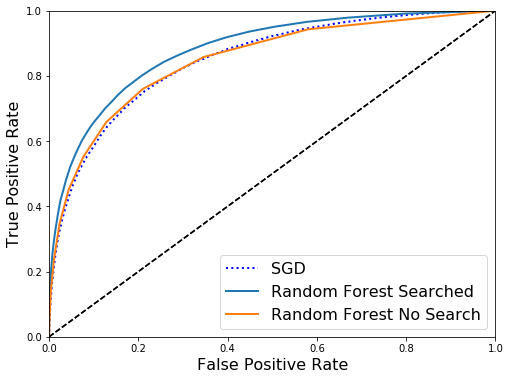

0.8803217513008094
0.8476548616919741


In [90]:
weather_scores_forest = weather_probas_forest[:, 1] # score = probability of positive class | search forest
weather_scores_forest_bland = weather_probas_forest_bland[:, 1] # non-search forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(weather_labels_num, weather_scores_forest)
fpr_forest2, tpr_forest2, thresholds_forest2 = roc_curve(weather_labels_num, weather_scores_forest_bland)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest Searched")
plot_roc_curve(fpr_forest2, tpr_forest2, "Random Forest No Search")
plt.legend(loc="lower right", fontsize=16)
plt.show()

# No noteable improvement whatsoever
print(roc_auc_score(weather_labels_num, weather_scores_forest))
print(roc_auc_score(weather_labels_num, weather_scores_forest_bland))

In [94]:
weather_train_pred_40 = (weather_scores_forest > .4)
weather_train_pred_40_bland = (weather_scores_forest_bland > .4)

print('precision: ', precision_score(weather_labels_num, weather_train_pred_40))
print('recall: ', recall_score(weather_labels_num, weather_train_pred_40))
print('precision_bland: ', precision_score(weather_labels_num, weather_train_pred_40_bland))
print('recall_bland: ', recall_score(weather_labels_num, weather_train_pred_40_bland))
print("F1 Score: ", f1_score(weather_labels_num, weather_train_pred_40))
print("F1 Score: ", f1_score(weather_labels_num, weather_train_pred_40_bland))

precision:  0.6804249923483888
recall:  0.6215104437078158
precision_bland:  0.6692795277495525
recall_bland:  0.5524182275649986
F1 Score:  0.6496347317887706
F1 Score:  0.6052597033212269


In [92]:
#gridsearch forest
forest_train_pred_forest = cross_val_predict(grid_search, weather_prepared, weather_labels_num, cv=3)
print('precision: ', precision_score(weather_labels_num, forest_train_pred_forest))
# Up nearly 9 percent
print('recall: ', recall_score(weather_labels_num, forest_train_pred_forest))
print("F1 score: ", f1_score(weather_labels_num, forest_train_pred_forest))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, max_features=40, n_estimators=50, score=0.6020353508302089, total=  11.1s
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[CV]  bootstrap=False, max_features=40, n_estimators=50, score=0.6074528901122168, total=   8.2s
[CV] bootstrap=False, max_features=40, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s


[CV]  bootstrap=False, max_features=40, n_estimators=50, score=0.6040702056638312, total=   8.9s
[CV] bootstrap=False, max_features=50, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=50, n_estimators=50, score=0.6092771467997028, total=  10.3s
[CV] bootstrap=False, max_features=50, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=50, n_estimators=50, score=0.607952747600464, total=  10.9s
[CV] bootstrap=False, max_features=50, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=50, n_estimators=50, score=0.6027426612384831, total=  10.1s
[CV] bootstrap=False, max_features=60, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=60, n_estimators=50, score=0.6000211797098379, total=  16.0s
[CV] bootstrap=False, max_features=60, n_estimators=50 ...............
[CV]  bootstrap=False, max_features=60, n_estimators=50, score=0.6052188552188552, total=  15.3s
[CV] bootstrap=False, max_features=60, n_estimators=50 .........

KeyboardInterrupt: 

In [35]:
#non gridsearch forest
forest_train_pred_forest_bland = cross_val_predict(forest_clf, weather_prepared, weather_labels_num, cv=3)
print('precision: ', precision_score(weather_labels_num, forest_train_pred_forest))
# Up nearly 9 percent
print('recall: ', recall_score(weather_labels_num, forest_train_pred_forest_bland))
print("F1 score: ", f1_score(weather_labels_num, forest_train_pred_forest_bland))

precision:  0.7752506265664161
recall:  0.49414912736131633
F1 score:  0.6035756969682188


In [95]:
conf_mx = confusion_matrix(weather_train_pred_40, weather_labels_num)
conf_mx

array([[81452,  9477],
       [ 7309, 15562]])

In [96]:
conf_mx = confusion_matrix(weather_train_pred_40_bland, weather_labels_num)
conf_mx

array([[81926, 11207],
       [ 6835, 13832]])

# Prepare and Run Test Data!

In [97]:
test_set = test_set.dropna(subset=["RainTomorrow"])
test_labels = test_set['RainTomorrow'].copy()

# binarizes labels 
test_labels_num = test_labels.map({"Yes":1, "No":0})#.dropna() #lose ~25000 entrys if drop null rows
test_labels_num.shape

(28446,)

In [98]:
Month = []
for date in test_set['Date']:
    Month.append(float(date[5]+date[6]))
    
test_set['Month'] = Month
test_set.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month
34746,2012-05-29,SydneyAirport,11.6,16.6,7.2,3.0,2.2,S,43.0,WSW,...,1031.6,1030.8,7.0,7.0,13.8,16.0,Yes,0.8,No,5.0
127100,2009-09-29,Walpole,5.8,13.0,12.2,NaN,NaN,SSW,48.0,SW,...,1007.4,1008.2,NaN,NaN,7.9,11.3,Yes,1.4,Yes,9.0
84778,2010-07-13,Brisbane,11.6,23.9,0.0,1.6,9.8,N,20.0,SW,...,1023.0,1018.8,1.0,7.0,16.8,22.0,No,0.0,No,7.0
50983,2014-06-26,Tuggeranong,7.6,14.4,0.0,NaN,NaN,WNW,65.0,WNW,...,1018.2,1019.0,NaN,NaN,10.6,12.2,No,0.0,No,6.0
5707,2017-08-21,BadgerysCreek,2.8,14.6,0.0,NaN,NaN,N,17.0,NaN,...,1020.2,1015.7,NaN,NaN,8.8,14.3,No,0.0,No,8.0


In [99]:
test_train = test_set.drop(['RISK_MM','Date','RainTomorrow'], axis=1)
                               # drop RISK_MM because if > 1, rain tomorrow is true. Using as a predictor would give
                               # false appearance of high accuracy


In [100]:
test_prepared = full_pipeline2.fit_transform(test_train)

In [101]:
dfTestPrep = pd.DataFrame(test_prepared)
dfTestPrep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28446 entries, 0 to 28445
Columns: 127 entries, 0 to 126
dtypes: float64(127)
memory usage: 27.6 MB


In [104]:
test_predict = grid_search.predict(test_prepared)

In [112]:
print('precision: ', precision_score(test_labels_num, test_predict))
print('recall: ', recall_score(test_labels_num, test_predict))
print("F1 Score: ", f1_score(test_labels_num, test_predict))
print("AUC: ", roc_auc_score(test_labels_num, test_predict))

precision:  0.7484378616061097
recall:  0.5203539823008849
F1 Score:  0.613895216400911
AUC:  0.7357291480484677


## Confusion Matrix

In [113]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_labels_num, test_predict)

array([[21144,  1087],
       [ 2981,  3234]])